In [1]:
# Import

import os,sys
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../new_iteration/")
import pickle
import argparse
from sklearn.metrics import confusion_matrix
from datetime import datetime

from vrae.vrae import VRAEC
from vrae.utils import *
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data as data2
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from tas_utils_bs import get_trainValLoader, get_testLoader
import plotly


In [2]:
# Set hyper params
num_class = 20
sequence_length = 75
number_of_features = 60
hidden_size = 90
hidden_layer_depth = 1
latent_length = 40
batch_size = 32
learning_rate = 0.0005
n_epochs = 20
dropout_rate = 0.2
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
header = "CNN"
w_r = 0.0001
w_k = 1
w_c = 1
np.random.seed(1)
torch.manual_seed(1)

In [3]:
# Load data
data_dir = '../../new_data_folder/'
kfold_number = 0

logDir = 'models_and_stat/'
model_name = 'IcubCNN_hs_{}_ll_{}_hl{}_lr_{}_wr_{}_wk_{}_wc_{}_{}'.format(hidden_size, latent_length, hidden_layer_depth, learning_rate, w_r,w_k, w_c, str(kfold_number))
device = torch.device("cuda:1")

train_loader, val_loader, train_dataset, val_dataset = get_trainValLoader(data_dir, k=kfold_number, spike_ready=False, batch_size=batch_size)
test_loader, test_dataset = get_testLoader(data_dir, spike_ready=False, batch_size=batch_size)


In [4]:
# Create model

# Create model
model = VRAEC(num_class=num_class,
            sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name,
            header=header,
            w_r = w_r, 
            w_k = w_k, 
            w_c = w_c,
            device = device)

model.to(device)

loss weights for vraec w_r: 0.0001, w_k: 1, w_c: 1


/home/students/student6_16/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



VRAE(n_epochs=20,batch_size=32,cuda=True)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
cl_loss_fn = nn.NLLLoss()
recon_loss_fn = nn.MSELoss()

In [6]:
# Train

training_start=datetime.now()
#split fit
epoch_train_loss = []
epoch_train_acc = []
epoch_val_loss = []
epoch_val_acc = []
max_val_acc = 0

for epoch in range(n_epochs):
    
    # TRAIN
    model.train()
    correct = 0
    train_loss = 0
    train_num = 0
    for i, (XI, XB,  y) in enumerate(train_loader):
        if model.header == 'CNN':
            x = XI
        else:
            x = XB
        x, y = x.to(device), y.long().to(device)
        if x.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break
        train_num += x.size(0)
        optimizer.zero_grad()
  
        x_decoded, latent, output = model(x)

        # construct loss function
        cl_loss = cl_loss_fn(output, y)
        latent_mean, latent_logvar = model.lmbd.latent_mean, model.lmbd.latent_logvar
        kl_loss = -0.5 * torch.mean(1 + latent_logvar - latent_mean.pow(2) - latent_logvar.exp())
        recon_loss = recon_loss_fn(x_decoded, x)
        loss = w_r*recon_loss + w_k*kl_loss + w_c*cl_loss
#         loss=w_c*cl_loss
        loss.backward()
#         if model.clip:
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = model.max_grad_norm)
        optimizer.step()
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()

        # accumulator
        train_loss += loss.item()

    # fill stats
    print("train last batch: recon_loss {}, kl_loss {}, cl_loss {}".format(recon_loss, kl_loss, cl_loss))
    train_accuracy = correct / train_num # len(train_loader.dataset)
    train_loss /= train_num #len(train_loader.dataset)
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_accuracy) 
    
    # VALIDATION
    model.eval()
    correct = 0
    val_loss = 0
    val_num = 0
    for i, (XI, XB,  y) in enumerate(val_loader):
        if model.header == 'CNN':
            x = XI
        else:
            x = XB
        x, y = x.to(device), y.long().to(device)
        if x.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break
        val_num += x.size(0)
        x_decoded, latent, output = model(x)

        # construct loss function
        cl_loss = cl_loss_fn(output, y)
        latent_mean, latent_logvar = model.lmbd.latent_mean, model.lmbd.latent_logvar
        kl_loss = -0.5 * torch.mean(1 + latent_logvar - latent_mean.pow(2) - latent_logvar.exp())
        recon_loss = recon_loss_fn(x_decoded, x)
        loss = w_r*recon_loss + w_k*kl_loss + w_c*cl_loss
    
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        
        # accumulator
        val_loss += loss.item()
    
#     print("test last batch: recon_loss {}, kl_loss {}, cl_loss {}".format(recon_loss, kl_loss, cl_loss))
    # fill stats
    val_accuracy = correct / val_num# / len(val_loader.dataset)
    val_loss /= val_num #len(val_loader.dataset)

    epoch_val_loss.append(val_loss)  # only save the last batch
    epoch_val_acc.append(val_accuracy)

    print('Epoch: {} Loss: train {}, valid {}. Accuracy: train: {}, valid {}'.format(epoch, train_loss, val_loss, train_accuracy, val_accuracy))
    
    # choose model
    if max_val_acc <= val_accuracy:
        print('Saving model at ', epoch, ' epoch')
        max_val_acc = val_accuracy
        torch.save(model.state_dict(), logDir + model_name + '.pt')

training_end =  datetime.now()
training_time = training_end -training_start 
print("training takes time {}".format(training_time))

train last batch: recon_loss 227.67889404296875, kl_loss 0.048235274851322174, cl_loss 2.935081958770752
Epoch: 0 Loss: train 0.09283693838450643, valid 0.09338268886009853. Accuracy: train: 0.0642361111111111, valid 0.13020833333333334
Saving model at  0  epoch
train last batch: recon_loss 188.7493896484375, kl_loss 0.06841085106134415, cl_loss 2.7903664112091064
Epoch: 1 Loss: train 0.08934203742278947, valid 0.09115312496821086. Accuracy: train: 0.16145833333333334, valid 0.2604166666666667
Saving model at  1  epoch
train last batch: recon_loss 210.40838623046875, kl_loss 0.10310997068881989, cl_loss 2.757532835006714
Epoch: 2 Loss: train 0.08494830545451906, valid 0.08730938533941905. Accuracy: train: 0.3107638888888889, valid 0.3489583333333333
Saving model at  2  epoch
train last batch: recon_loss 212.3280487060547, kl_loss 0.2943575978279114, cl_loss 2.1975960731506348
Epoch: 3 Loss: train 0.07683055392569965, valid 0.08221599087119102. Accuracy: train: 0.4322916666666667, valid

In [7]:
model.is_fitted = True

In [8]:
# testing set check
net_trained = VRAEC(num_class=num_class,
            sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name,
            header=header,
            w_r = w_r, 
            w_k = w_k, 
            w_c = w_c,
            device = device)

net_trained.load_state_dict(torch.load(logDir + model_name + '.pt'))
net_trained.eval()

loss weights for vraec w_r: 0.0001, w_k: 1, w_c: 1


VRAE(n_epochs=20,batch_size=32,cuda=True)

In [9]:
correct = 0
test_num = 0
for i, (XI, XB,  y) in enumerate(test_loader):
    if model.header == 'CNN':
        x = XI
    else:
        x = XB
    x, y = x.to(device), y.long().to(device)
    
    if x.size(0) != batch_size:
        print(" test batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
        break
    test_num += x.size(0)
    x_decoded, latent, output = model(x)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
    
test_acc = correct / test_num #len(test_loader.dataset)

print('Test accuracy for', str(kfold_number), ' fold : ', test_acc)

 test batch 6 size 8 < 32, skip
Test accuracy for 0  fold :  0.7708333333333334


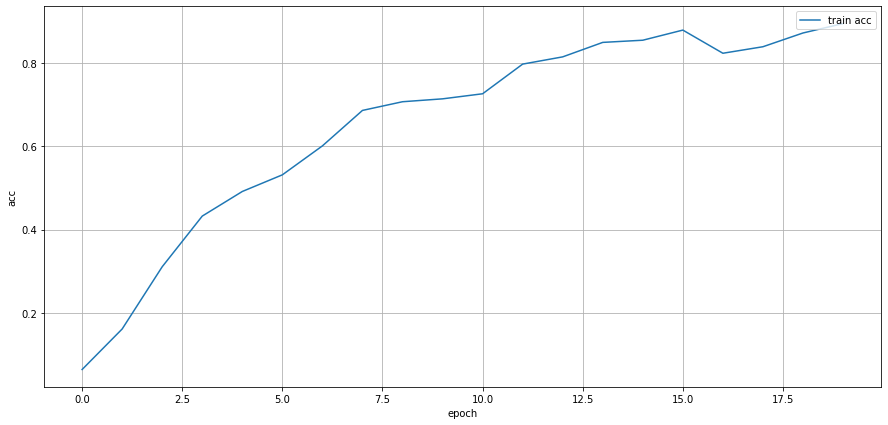

In [10]:
# save stats
all_stats = [
    epoch_train_loss,
    epoch_train_acc,
    epoch_val_loss,
    epoch_val_acc,
    test_acc
]

pickle.dump(all_stats, open(logDir + model_name + '_stats.pkl', 'wb'))

assert n_epochs == len(epoch_train_acc), "different epoch length {} {}".format(n_epochs, len(epoch_train_acc))
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.arange(n_epochs), epoch_train_acc, label="train acc")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.grid(True)
plt.legend(loc='upper right')
plt.show()

